# １、目標：アメリカの株式市場からポートフォリオを組み、3ヶ月の短期投資をシミュレーションし、その実際の収益を平均分散モデルとブラックリッターマンモデル、の二つモデルで比較して、評価する。学習期間を2012年10月1日から2019年9月12日までにします。シミュレーション期間は2019年9月13日から2019年12月13日までにします。銘柄を20にします。

## （１）外部の情報としては、まず無リスク金利とマーケットプライスを知る必要がある。無リスク金利として、52 Week Treasury Billを使って測る。

In [42]:
#シミュレーション期間
datetime.datetime(2019, 9, 12)-datetime.datetime(2012, 10, 1)

datetime.timedelta(days=2537)

In [45]:
import quandl
quandl.ApiConfig.api_key = 'key'
Wk_Bank_Discount_Rate_52=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2012, 10, 1), 
                          end_date=datetime.datetime(2019, 9, 12))

In [159]:
2537/(52*7)

6.96978021978022

In [86]:
#満期日が354日の債券を354日ごとに利回り取得する。
yield_list=[]
for i in range(7):
    yield_list.append(Wk_Bank_Discount_Rate_52[datetime.datetime(2012, 10, 1)+datetime.timedelta(days=364*i):]\
                      ["52 Wk Bank Discount Rate"][0])

In [93]:
yield_list

[0.16, 0.09, 0.1, 0.32, 0.56, 1.27, 2.51]

# （２）6年から7年目までの利回りを求める

In [103]:
(datetime.datetime(2012, 10, 1)+datetime.timedelta(days=364*7))-(datetime.datetime(2019, 9, 12))

datetime.timedelta(days=11)

## 一年未満のゼロクーポン債の計算式  
## r = [(F-P)/F]*[365/M]
## F=債券の額面価値  
## m＝債券の満期の日数
## P=債券の価格  
## r=債券の利回り 

## [(F-P)/F]=6年から7年目までの利回り（risk_free）と定義し

In [111]:
risk_free6_7=(yield_list[6]/100)/(365/(365-11))

In [113]:
risk_free6_7

0.024343561643835613

## 学習期間2012年10月1日から2019年9月12日までの利回りS=(1+S0)x(1+S1)x(1+S2)x(1+S3)x(1+S4)x1+S5)x(1+S6)-1

In [125]:
S=(1+yield_list[0]/100)*(1+yield_list[1]/100)*(1+yield_list[2]/100)*\
(1+yield_list[3]/100)*(1+yield_list[4]/100)*(1+yield_list[5]/100)*(1+risk_free6_7/100)-1

In [126]:
S

0.025459211493963796

## ゼロクーポン債だから、0から6年まで全ての1年国債の利回りの掛け合わせ＝2012年10月1日から2019年9月12日までのスポットレートになる。2012年10月1日にこの債券に1ドル投資すれば、2019年9月12日にほぼ確実に1.025の資産が手に入る。これを安全資産と定義され、この安全資産の金利を無リスク金利にする。

In [122]:
risk_free=S

In [123]:
risk_free

0.025459211493963796

## (３)選択した銘柄だダウンロード

In [129]:
# 基本のライブラリを読み込む
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from scipy import stats
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


data=pd.DataFrame([])
name=["AAPL","GOOGL","MCD","GM","XOM","BRK-A","MSFT","WFC","AMZN","FB","JPM","V",
             "WMT","MA","PG","BAC","T","INTC","UNH","DIS"]

columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

for idx,stock in enumerate(name):
    names = pdr.get_data_yahoo(stock, start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
    j=columns[idx]
    data[j]=names["Adj Close"]

## （４）時系列推移と収益率をプロット

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


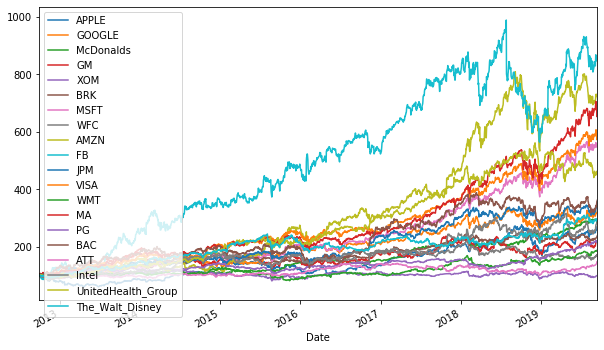

In [130]:
(data / data.ix[0] * 100).plot(figsize=(10, 6))

In [131]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,APPLE,GOOGLE,McDonalds,GM,XOM,BRK,MSFT,WFC,AMZN,FB,JPM,VISA,WMT,MA,PG,BAC,ATT,Intel,UnitedHealth_Group,The_Walt_Disney
Date,,,,,,,,,,,,,,,,,,,,
2012-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02,0.002908,-0.006308,-0.011590,0.025231,-0.000872,0.001705,0.005748,0.003452,-0.005611,0.012653,-0.001221,-0.005353,-0.004059,0.001662,-0.009548,-0.003354,0.001588,0.003509,0.006004,-0.008292
2012-10-03,0.015217,0.007252,-0.006399,0.029542,-0.000219,0.006270,0.006720,0.017649,0.021007,-0.019955,0.005891,0.018360,0.006083,0.034596,0.005508,0.019957,0.009476,-0.012778,0.001056,0.015945
2012-10-04,-0.006949,0.007252,0.007498,0.010604,0.005655,0.009029,0.005677,0.014844,0.017623,0.005482,0.023224,0.008268,0.006984,0.002361,0.003032,0.032400,0.004444,-0.003554,0.019334,0.003045
2012-10-05,-0.021541,-0.000521,-0.000329,0.006067,0.003572,0.002023,-0.006012,-0.003621,-0.007553,-0.048540,-0.002634,0.004215,0.005472,0.007158,0.003596,-0.009610,-0.001056,0.009302,-0.014596,0.006440


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d6cff50>,
      dtype=object)

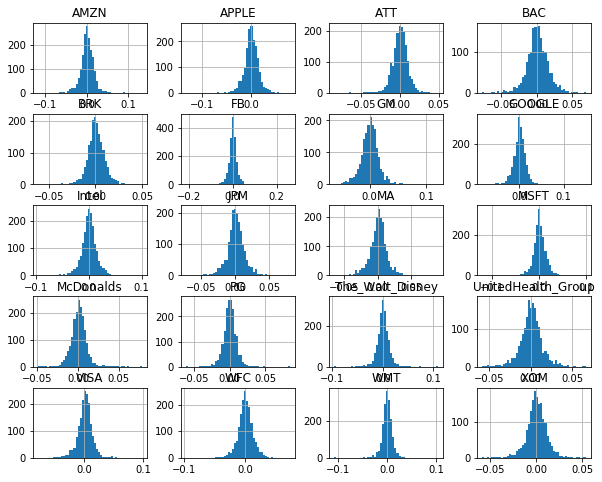

In [132]:
log_returns.hist(bins=50, figsize=(10, 8))

# ２、平均分散モデル
## （１）モデル最適化

In [133]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data,frequency=252)

#最小分散ポートフォリオ
EF_min = EfficientFrontier(mu, S)
#最小分散ポートフォリオを計算する
EF_min.min_volatility()
#ポートフォリオの年リターン、ボラティリティ、シャープ・レシオを求める
EF_min.portfolio_performance(verbose=True)

Expected annual return: 12.9%
Annual volatility: 11.1%
Sharpe Ratio: 0.98


(0.12888700690418314, 0.11066756525154166, 0.9839107479837349)

In [134]:
#CAPM理論に基づき、平均分散モデルを最適化
#無リスク金利を入れる
EF = EfficientFrontier(mu, S)
weights = EF.max_sharpe(risk_free_rate=risk_free)
#ポートフォリオの年リターン、ボラティリティ、シャープ・レシオを求める
EF.portfolio_performance(verbose=True)

Expected annual return: 25.9%
Annual volatility: 15.2%
Sharpe Ratio: 1.57


(0.2587610442909802, 0.15237215921832675, 1.5669597747766437)

In [135]:
#各ウェイトをプリントする
EF.clean_weights()

{'APPLE': 0.0,
 'GOOGLE': 0.0,
 'McDonalds': 0.19341,
 'GM': 0.0,
 'XOM': 0.0,
 'BRK': 0.0,
 'MSFT': 0.0876,
 'WFC': 0.0,
 'AMZN': 0.06023,
 'FB': 0.12256,
 'JPM': 0.0,
 'VISA': 0.10965,
 'WMT': 0.0,
 'MA': 0.16992,
 'PG': 0.03833,
 'BAC': 0.0,
 'ATT': 0.0,
 'Intel': 0.0,
 'UnitedHealth_Group': 0.21831,
 'The_Walt_Disney': 0.0}

## （２）シミュレーションのために、各銘柄の2019年9月13日から2019年12月13日までのデータを取る。

In [136]:
data2=pd.DataFrame([])
name2=["AAPL","GOOGL","MCD","GM","XOM","BRK-A","MSFT","WFC","AMZN","FB","JPM","V",
             "WMT","MA","PG","BAC","T","INTC","UNH","DIS"]

columns2=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

for idx,stock in enumerate(name2):
    name = pdr.get_data_yahoo(stock, start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2019, 12, 13))
    j=columns[idx]
    data2[j]=name["Adj Close"]

## （３）2019年9月13日から2019年12月13日まで運用したらポートフォリオの平均収益は  
## R=1r1+w2r2+...+wn*rn  
## ri=個々の銘柄のリターン  
## wi=個々の銘柄のウェイト  
## R=ポートフォリオの平均収益  

In [137]:
Mean_variance_return=np.sum(np.array(EF.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [138]:
Mean_variance_return

0.2738461973315342

## （４）平均分散モデルポートフォリオのボラティリティ

In [139]:
from pypfopt import objective_functions
objective_functions.volatility(EF.weights, risk_models.sample_cov(data2))

0.013567326921969883

# ３、ブラック–リッターマンモデル

## （１）シミュレーション期間、2019年9月13日から2019年12月13日までの各銘柄のリターンを算出

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


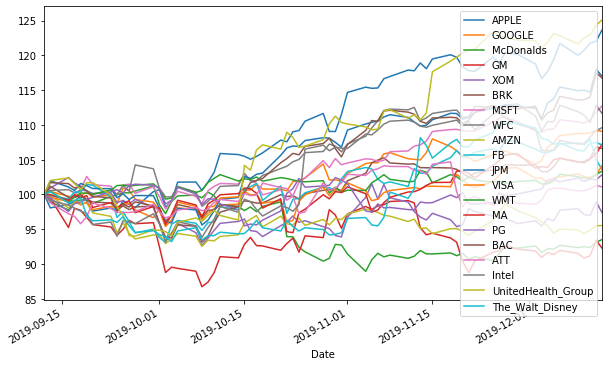

In [140]:
(data2 / data2.ix[0] * 100).plot(figsize=(10, 6))

In [141]:
expected_returns.mean_historical_return(data2, frequency=252)

APPLE                 0.843804
GOOGLE                0.348170
McDonalds            -0.243882
GM                   -0.279763
XOM                  -0.084209
BRK                   0.253862
MSFT                  0.477013
WFC                   0.441788
AMZN                 -0.166396
FB                    0.156823
JPM                   0.622150
VISA                  0.172853
WMT                   0.133405
MA                    0.291584
PG                    0.122861
BAC                   0.616208
ATT                   0.057221
Intel                 0.383329
UnitedHealth_Group    0.901564
The_Walt_Disney       0.289755
dtype: float64

## （３）銘柄ごとの評論家レビューの設定  
以上の図とデータを参考すると、  
例えば、ある評論家は、3ヶ月以降、アップル、ユナイテッドヘルス・グループ、グーグル、マイクロソフト、フェイスブック、バンク・オブ・アメリカとJPモルガンの株はそれぞれ、80、80、40、50、20、50、50パーセント、に上がると予測し、他の銘柄は未知だとします。そうすると、ブラックリッターマンモデルを利用し、以下のように設定する

In [142]:
from pypfopt.black_litterman import BlackLittermanModel
S = risk_models.sample_cov(data)

viewdict = {"APPLE": 0.8,
           "UnitedHealth_Group": 0.8, "GOOGLE": \
            0.4,"MSFT": 0.5,"FB": 0.2,"JPM": 0.5,"BAC": 0.5}

In [143]:
bl = BlackLittermanModel(S, absolute_views=viewdict)
rets = bl.bl_returns()

/usr/local/anaconda3/lib/python3.7/site-packages/pypfopt/black_litterman.py:173: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


## (4)各銘柄のリターンを計算する

In [144]:
rets

APPLE                 0.511832
GOOGLE                0.361083
McDonalds             0.171037
GM                    0.324279
XOM                   0.240730
BRK                   0.271457
MSFT                  0.409811
WFC                   0.330579
AMZN                  0.388470
FB                    0.291301
JPM                   0.391099
VISA                  0.327193
WMT                   0.176348
MA                    0.361000
PG                    0.153025
BAC                   0.447477
ATT                   0.171766
Intel                 0.336823
UnitedHealth_Group    0.481990
The_Walt_Disney       0.253864
dtype: float64

## （５）市場価格としてSP500を導入する

In [145]:
SP500 = pdr.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))

In [146]:
market_prices=SP500["Close"]

## （６）同じく学習期間を2012年10月1日から2019年9月12日までにします。

In [147]:
from pypfopt import black_litterman

delta = black_litterman.market_implied_risk_aversion(market_prices,risk_free_rate=risk_free)

ef = EfficientFrontier(rets, S)

bl.bl_weights(delta)
weights = bl.clean_weights()

In [148]:
bl.portfolio_performance(verbose=True)

Expected annual return: 47.0%
Annual volatility: 17.0%
Sharpe Ratio: 2.65


(0.4703876559705822, 0.1696767153273029, 2.654386932831612)

In [149]:
weights

{'APPLE': 0.26412,
 'GOOGLE': 0.04255,
 'McDonalds': 0.0,
 'GM': 0.0,
 'XOM': 0.0,
 'BRK': 0.0,
 'MSFT': 0.10103,
 'WFC': 0.0,
 'AMZN': 0.0,
 'FB': -0.04636,
 'JPM': 0.15623,
 'VISA': 0.0,
 'WMT': 0.0,
 'MA': 0.0,
 'PG': 0.0,
 'BAC': 0.04891,
 'ATT': 0.0,
 'Intel': 0.0,
 'UnitedHealth_Group': 0.43351,
 'The_Walt_Disney': 0.0}

In [150]:
sum(weights.values())

0.9999899999999999

## （７）2019年9月13日から2019年12月13日まで運用したらポートフォリオの平均収益は  
## R=1r1+w2r2+...+wn*rn
## ri=個々の銘柄のリターン
## wi=個々の銘柄のウェイト
## R=ポートフォリオの平均収益

In [151]:
BL_return=np.sum(np.array(bl.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [152]:
BL_return

0.796784317273889

## （８）ポートフォリオのボラティリティ 

In [153]:
from pypfopt import objective_functions
objective_functions.volatility(bl.weights, risk_models.sample_cov(data2))

0.022966830582348

# ４、ポートフォリオの比較

## （１）ポートフォリオウェイトの比較

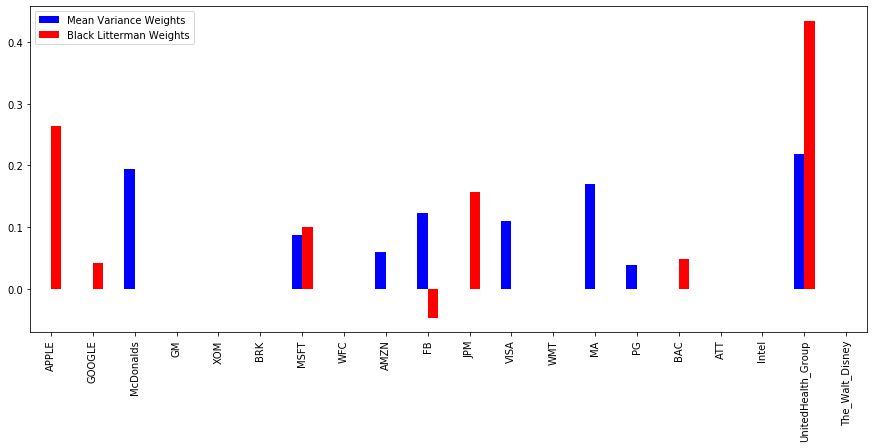

In [154]:
df = pd.DataFrame([EF.weights.reshape(20),np.array(list(bl.weights)).reshape(20)],
                  columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"],
                  index=['Mean Variance Weights','Black Litterman Weights'])
df.T.plot(kind='bar', color='br',figsize=(15, 6))

## （２）分析
## 青がもともとの株のウェイト、赤が新しく計算された、投資家のビューを組み入れたポートフォリオウェイトを表しています。アップル、グールル、JPモルガン、ユナイテッドヘルス・グループなどの株が上がるという情報が入ったことから、ブラックリッターマンモデルで、ウェイトが新しく算出されました。

## （３）シミュレーションしたポートフォリオ収益率、ボラティリティの比較

In [155]:
df2 = pd.DataFrame([[objective_functions.volatility(EF.weights, risk_models.sample_cov(data2)),\
                    objective_functions.volatility(bl.weights, risk_models.sample_cov(data2))
                    ],[Mean_variance_return,BL_return]],columns=["平均分散モデル","ブラックリッターマンモデル"],index=["ボラティリティ","収益率"])
    
df2  

,平均分散モデル,ブラックリッターマンモデル
ボラティリティ,0.013567,0.022967
収益率,0.273846,0.796784


# ５、結論
## 2019年9月13日から2020年1月10日まで運用で、平均分散モデルと、ブラックリッターマンモデルを比較して、ポートフォリオの平均収益を求めた結果、ブラックリッターマンモデルを取り入れることで、ボラティリティがわずか、0.9パーセント上がり、ブラックリッターマンモデルの収益率が平均分散モデルよりも52.29%まであげることができた結果になりました。関係研究論文を読めば、結果としては当たり前のようになりますが、他人より優れた情報を持つと信じる人は、市場平均のポートフォリオ以上に高い成績を収めることを示唆しています。ポートフォリオ運用は、アルゴリズムだけでなく、評論家の情報や市場の情報、そして何よりも企業分析をきちんと行うことが大事だと思われます。

# ６、参考文献リスト
## 参考文献、デービッド・G・ ルーエンバーガー 今野浩・鈴木賢一・枇々木規雄訳『金融工学入門　第2版』 日本経済新聞社（２０１５）
## 参考文献、小松高広　『最適投資戦略』 朝倉書店（２０１８）
## 参考文献、PyPortfolioOpt、https://pyportfolioopt.readthedocs.io/en/latest/